<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/vgg_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrianedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0-rc1


In [2]:
# download the data
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!unzip -qq -o Food-5K.zip
!mv Food-5K/* .

--2019-12-24 06:58:16--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 2606:4700:30::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  12.7MB/s    in 35s     

2019-12-24 06:58:52 (12.1 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



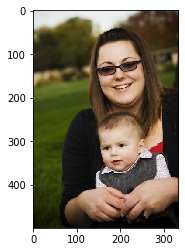

In [3]:
# look at an image for fun
plt.imshow(image.load_img('training/0_807.jpg'))
plt.show()

In [0]:
# split data into directories
!mkdir -p data/train/nonfood
!mkdir -p data/train/food
!mkdir -p data/test/nonfood
!mkdir -p data/test/food

!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [0]:
# data file paths
TRAIN_PATH = "data/train"
TEST_PATH = "data/test"

folders = glob(TRAIN_PATH + "/*")
train_image_files = glob(TRAIN_PATH + "/*/*.jpg")
test_image_files = glob(TEST_PATH + "/*/*.jpg")

# hyper params
IMAGE_SIZE = [200, 200]
BATCH_SIZE = 128

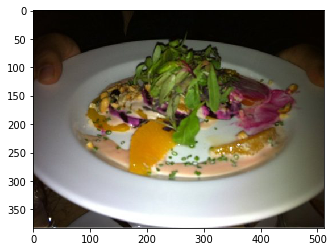

In [6]:
plt.imshow(image.load_img(np.random.choice(train_image_files)))
plt.show()

In [7]:
# init pre trained model
pre_trained_model = PretrianedModel(input_shape=(IMAGE_SIZE) + [3], weights="imagenet", include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
# flatten the features from pre trained model output
x = Flatten()(pre_trained_model.output)

In [9]:
# create model
model = Model(inputs=pre_trained_model.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [10]:
# craete an image generator object
generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# create train & test generator which fetchs images from HDD
train_generator = generator.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = generator.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
Ntrain = len(train_image_files)
Ntest = len(test_image_files)

# figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_test = np.zeros((Ntest, D))
Y_test = np.zeros(Ntest)

In [12]:
# populate X_train and Y_train
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [13]:
# populate X_test and Y_test
i = 0
for x, y in test_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_test and Y_test
  X_test[i:i + sz] = features
  Y_test[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Ntest:
    print('breaking now')
    break
print(i)

breaking now
1000


In [0]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [16]:
# build the model

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
logistic_regression_model = Model(i, x)

logistic_regression_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
logistic_regression_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18432)]           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 18433     
Total params: 18,433
Trainable params: 18,433
Non-trainable params: 0
_________________________________________________________________


In [17]:
# train the model
r = logistic_regression_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 1s 267us/sample - loss: 1.4882 - accuracy: 0.9140 - val_loss: 0.4705 - val_accuracy: 0.9750
Epoch 2/10
3000/3000 [==============================] - 0s 115us/sample - loss: 0.0589 - accuracy: 0.9930 - val_loss: 0.2838 - val_accuracy: 0.9820
Epoch 3/10
3000/3000 [==============================] - 0s 112us/sample - loss: 0.0111 - accuracy: 0.9983 - val_loss: 0.2877 - val_accuracy: 0.9820
Epoch 4/10
3000/3000 [==============================] - 0s 112us/sample - loss: 4.9499e-05 - accuracy: 1.0000 - val_loss: 0.2939 - val_accuracy: 0.9840
Epoch 5/10
3000/3000 [==============================] - 0s 114us/sample - loss: 1.9773e-05 - accuracy: 1.0000 - val_loss: 0.2942 - val_accuracy: 0.9840
Epoch 6/10
3000/3000 [==============================] - 0s 109us/sample - loss: 7.1402e-06 - accuracy: 1.0000 - val_loss: 0.2940 - val_accuracy: 0.9840
Epoch 7/10
3000/3000 [==============================

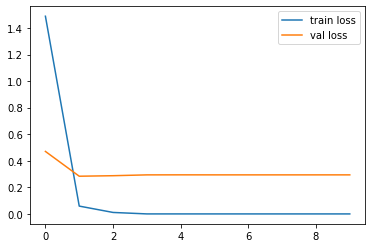

In [18]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

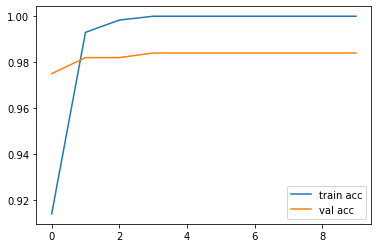

In [19]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()